# Powerline Supply Curve Analysis

This notebooks is organised as follows:

## Table of Contents
- [A. Set up](#a-set-up)
- [B. Task 1](#b-task-1)
- [C. Task 2](#c-task-2)
- [D. Task 3](#d-task-3)
- [E. Bonus 1](#e-bonus-1)
- [F. Bonus 2](#f-bonus-2)

## A. Set up

#### Importing Packages & Modules

In [1]:
import os,sys
sys.path.append(os.getcwd())

In [2]:
import pandas as pd
from src import functions as fn
import src.plotter as pt
import matplotlib.pyplot as plt
from importlib import reload
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


#### Importing Data

In [3]:
input_dir = './materials/'
bid_filename = 'raw_bid_data_2024-06-13.xlsx'
nem_filename = 'NEM Registration and Exemption List.xlsx'

In [4]:
raw_bids = pd.read_excel(input_dir + bid_filename)
nem_registery = pd.read_excel(input_dir + nem_filename, sheet_name='PU and Scheduled Loads')

In [5]:
df_bids, nem_registery = fn.prepare_data(raw_bids, nem_registery)

#### Check data set

In [6]:
print('Regions in dataset include: {}'.format(df_bids.Region.unique()))
print('Products in dataset include:{}'.format(df_bids['product'].unique()))
print('Number of duplicated rows:{}'.format(df_bids.duplicated().sum()))

Regions in dataset include: ['VIC1']
Products in dataset include:['ENERGY']
Number of duplicated rows:0


## B. Task 1

### Energy Supply Curve Calculation & Plotting

In [7]:
#inputs for calc_energy_supply_interval function
region = 'VIC1'
interval_datetime = '2024-06-13 11:10:00'

In [8]:
df_supply = fn.calc_energy_supply_interval(df_bids, region, interval_datetime)

In [9]:
df_supply.head()

,DUID,Price,Band_index,Volume,Cumulative_Volume,interval_datetime,rrp,forecasted_rrp,Fuel,TOTALCLEARED,Capacity
0,PIBESSG1,-1036.84,1,0,0,2024-06-13 11:10:00,540.6845,306.18688,Battery,NaN,7
1,WKIEWA2,-1011.00,1,0,0,2024-06-13 11:10:00,540.6845,306.18688,Hydro,NaN,31
2,WKIEWA1,-1011.00,1,0,0,2024-06-13 11:10:00,540.6845,306.18688,Hydro,NaN,31
3,GANNBG1,-1006.57,1,0,0,2024-06-13 11:10:00,540.6845,306.18688,Battery,NaN,30.875
4,CHYTWF1,-1005.68,1,57,57,2024-06-13 11:10:00,540.6845,306.18688,Wind,1.7,57.6


Plot functions

**Note**: on Github the plotly chart might not be displayed properly. So, if the output of `plot_energy_supply_curve` function in the next cell appears empty, please ensure you run it in a Jupyter notebook for proper visualization.

In [41]:
pt.plot_energy_supply_curve(df_bids , region, interval_datetime)

Supply curve by fuel

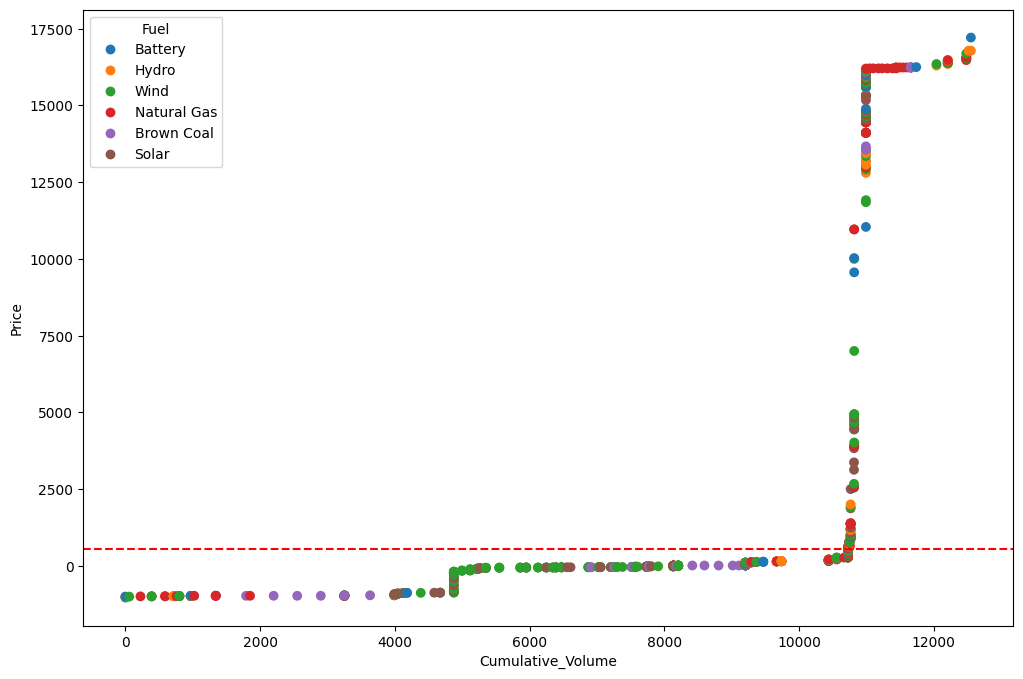

In [40]:
pt.plot_energy_supply_curve_by_fuel(df_bids , region, interval_datetime)

## C. Task 2

#### Insights

- The asset's capacity strongly correlates (97\%) with its ability to set the price, as demonstrated in the following cells.
- Below tables also show the DUID of the price setters.
- Hydro generally sets the price during early hours of the day and overnight.
- Batteries set the price more actively during peak periods, particularly the evening peak, due to higher profitability.
- Natural gas sets the price during the remaining periods in this specific dataset.

### Price Setting Analysis

Get Price Setter for one interval

In [12]:
price_setter = fn.find_price_setter_interval(df_supply)
price_setter

,DUID,Price,Band_index,Volume,Cumulative_Volume,interval_datetime,rrp,forecasted_rrp,Fuel,TOTALCLEARED,Capacity,dist_to_rrp
598,HBESSG1,598.78,8,20,10745,2024-06-13 11:10:00,540.6845,306.18688,Battery,NaN,200,58.0955


**Get Price Setter per interval for a date range**

In [13]:
start_date = '2024-06-13'
end_date = '2024-06-15'
region = 'VIC1'

price_setters = fn.price_setter_by_fuel(df_bids, region, start_date, end_date)
price_setters.head()

,DUID,Price,Band_index,Volume,Cumulative_Volume,interval_datetime,rrp,forecasted_rrp,Fuel,TOTALCLEARED,Capacity,dist_to_rrp
429,MORTLK11,145.03,6,75,9536,2024-06-13 04:05:00,147.37046,185.84589,Natural Gas,280.00000,283,2.34046
429,MORTLK11,145.03,6,75,9541,2024-06-13 04:10:00,147.80749,181.76851,Natural Gas,280.00000,283,2.77749
429,MORTLK11,145.03,6,75,9541,2024-06-13 04:15:00,146.10000,193.06039,Natural Gas,254.64908,283,1.07000
435,MURRAY,155.62,6,293,9839,2024-06-13 04:20:00,193.64681,146.10000,Hydro,610.00000,1500,38.02681
435,MURRAY,155.62,6,298,9839,2024-06-13 04:25:00,195.57997,196.05117,Hydro,605.00000,1500,39.95997


1. **Dominant Price Setters**




In [14]:
price_setters['Capacity'] = price_setters['Capacity'].astype(float)
price_set_summary = price_setters.groupby('DUID').agg(num_intervals = ('Price','count'), Capacity = ('Capacity','first'))
price_set_summary = price_set_summary.sort_values('num_intervals',ascending=False)


In [15]:
print('Correlation between the capacity and num of intervals as price setter:{:.2f}'.format(price_set_summary['num_intervals'].corr(price_set_summary['Capacity'])))

Correlation between the capacity and num of intervals as price setter:0.97


Text(0, 0.5, 'Capacity (MW)')

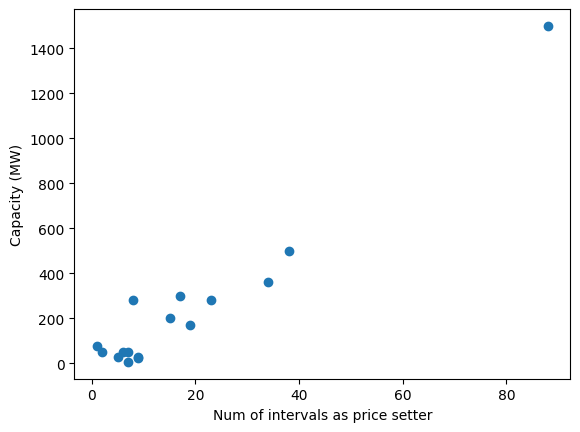

In [16]:
plt.scatter(price_set_summary.num_intervals, price_set_summary.Capacity)
plt.xlabel('Num of intervals as price setter')
plt.ylabel('Capacity (MW)')

2. **Price setting by fuel**



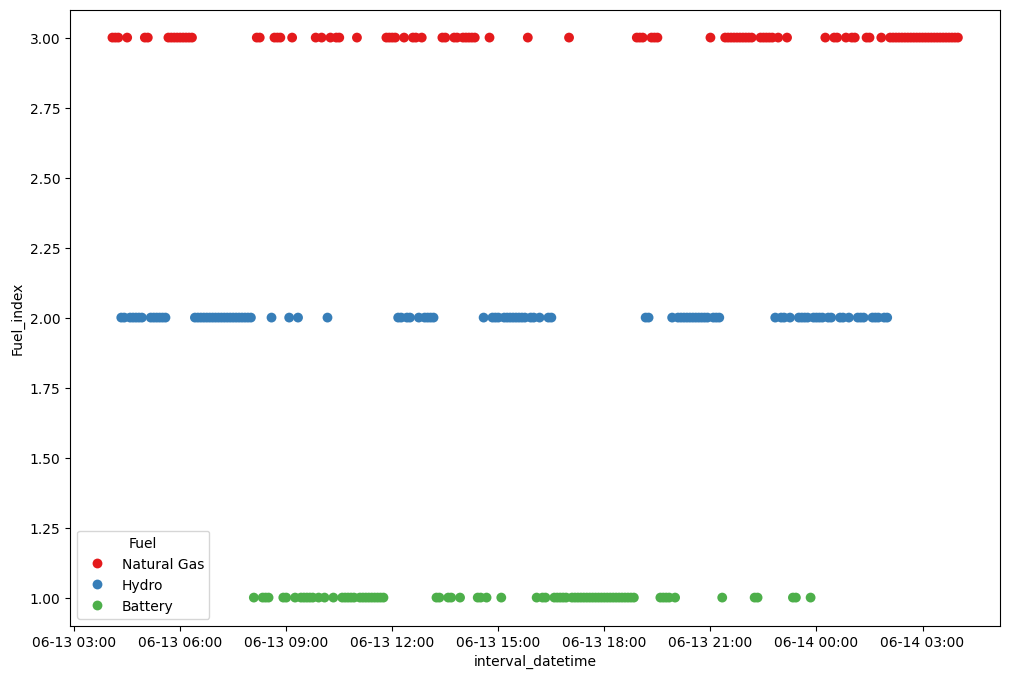

In [17]:
pt.plot_price_setter_by_fuel(price_setters)

Num of intervals each fuel sets price

In [18]:
price_setters[['DUID','Fuel']].groupby('Fuel').count()

,DUID
Fuel,
Battery,79
Hydro,105
Natural Gas,104


## D. Task 3

#### Insights

- There is a strong correlation between daily revenue and price setting power of an asset and its total revenue
- As expected, for batteries who set the price more actuvely during peak periods, their captured price are higher followed by Hydro and Gas.
- Among batteries, VBB who set the price more often has a 30\% correlation between interval revenue and interval price setting capbaility. 

Revenue calculations

In [19]:
df_revenue = fn.calc_gen_revenue(df_bids)
df_revenue.head()

,DUID,interval_datetime,TOTALCLEARED,rrp,revenue
0,HD1WF1,2024-06-13 04:05:00,0.0,147.37046,0.000000
1,CROWLWF1,2024-06-13 04:05:00,0.0,147.37046,0.000000
2,AGLSOM,2024-06-13 04:05:00,0.0,147.37046,0.000000
3,LYA1,2024-06-13 04:05:00,560.0,147.37046,6877.288133
4,MACARTH1,2024-06-13 04:05:00,0.0,147.37046,0.000000


**Correlation between an asset's daily revenue and the number of intervals it contributes as a price setter:**

In [26]:
df_daily_revenue_price_setters = fn.corr_revenue_vs_price_setting_intervals(df_revenue, price_setters)
print('correlation between daily revenue and power of price setting:{:.2f}'.format(df_daily_revenue_price_setters['revenue'].corr(df_daily_revenue_price_setters['num_price_set'])))

correlation between daily revenue and power of price setting:0.90


Text(0, 0.5, 'Revenue ($)')

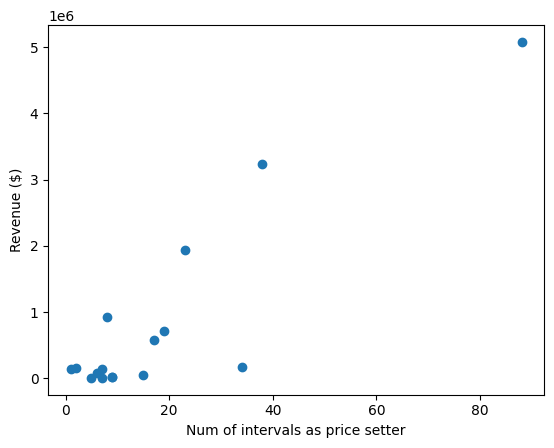

In [27]:
plt.scatter(df_daily_revenue_price_setters['num_price_set'],df_daily_revenue_price_setters['revenue'])
plt.xlabel('Num of intervals as price setter')
plt.ylabel('Revenue ($)')

**Correlation between captured price and price setting power over peak period**

In [28]:
df_revenue_daily_fuel = fn.corr_revenue_vs_price_setter_fuel(df_revenue, price_setters)
df_revenue_daily_fuel['captured_price'] = df_revenue_daily_fuel['revenue'] / df_revenue_daily_fuel['MWh']

df_revenue_daily_fuel

,revenue,TOTALCLEARED,MWh,num_price_set,num_peak_intvals,captured_price
Fuel,,,,,,
Battery,2.782014e+05,8242.42649,686.868874,79,21,405.028328
Hydro,5.654728e+06,190369.30317,15864.108597,105,18,356.447879
Natural Gas,7.321643e+06,273485.15417,22790.429514,104,11,321.259538


In [29]:
print('Correlation between captured price and price setting power over peak period:{:.2f}'
    .format(df_revenue_daily_fuel['num_peak_intvals'].corr(df_revenue_daily_fuel['captured_price']))
)

Correlation between captured price and price setting power over peak period:0.95


**Correlation between interval revenue and interval price setting power**

In [30]:
pt.plot_duid_revenue_with_price_setting(df_revenue, price_setters, DUID = 'VBBG1')

The correlation between revenue and price_set is: 0.3007138557477158


## E. Bonus 1

#### Insights

- The average success rate increases significantly (up to 90%) during peak periods, especially in the evening peak (period 216 - 240, 6-8pm), while the overnight period shows the lowest success rate.
- Success rate by fuel vs. time of day reveals that solar and wind have the lowest success rates in this specific period under investigation.
- The solar success rate improves throughout the day as asset availability increases, while wind sees a slight increase overnight.
- The average success rate for other fuels is greater than 90%, but during the day, as solar begins to clear more volume, dispatchable generators slightly reduce, with some spikes visible in the chart below.

### Clearing success rate

In [31]:
df_success_rates = fn.calc_clearing_success_rate(df_bids , region, start_date, end_date)

**Avg Success rate vs time of day (TOD)**

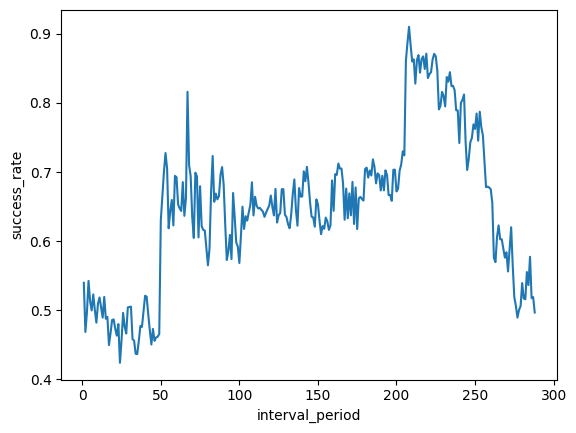

In [32]:
df_success_tod, df_success_by_fuel_tod = pt.plot_success_rate_by_tod(df_success_rates, by_fuel= False)

**Avg Success rate by fuel vs time of day (TOD)**

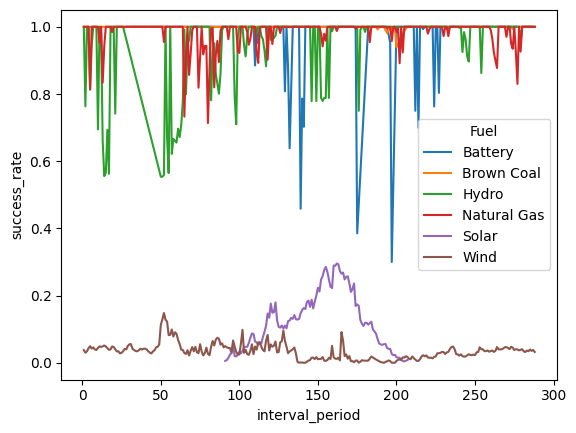

In [33]:
df_success_tod, df_success_by_fuel_tod = pt.plot_success_rate_by_tod(df_success_rates, by_fuel= True)

In [34]:
df_success_by_fuel_tod.groupby('Fuel').mean()

,interval_period,success_rate
Fuel,,
Battery,144.5,0.964904
Brown Coal,144.5,0.998910
Hydro,144.5,0.951324
Natural Gas,144.5,0.984613
Solar,144.5,0.123301
Wind,144.5,0.035601


## F. Bonus 2

### Price band prices vs. price setting

#### Insight:

To investigate the price setting pattern vs price bands, we also need to look at volume bid in each band. As Price bands do not change during the day however, the volume moves.

For clustering we used the following bin edges such that we can capture the dynamics of market and bidding behaviour better.

- The charts below show that units intending to set the price typically position their volumes in a price range that aligns with reasonable range expectations for the specific period. Significant movements in volume are often driven by the intention to either set the price or take advantage of anticipated high prices.

- Volume shifts from higher price bands to lower ones, particularly within the range of `<$100/MWh`, likely indicate the asset's intention to act as a price taker.

- To operate as a price taker, units tend to bid their volumes in the lowest price bands (e.g., `[-1000, 0]`).

- The VBB battery shifted volumes from higher price bands to the `<300` band during the morning and evening peaks, enabling it to set the price during these periods.



Price band clustering for top 5 price setter

In [35]:
#clustering the bid bands data based on price band value
price_bins = [-1000,0,50,100,150,200,300,1000,5000,10000,17000]
duids = price_set_summary.head().index.tolist()
df_price_band_clusters = fn.price_bands_clustering(df_bids, region, start_date, end_date, price_bins, duids)

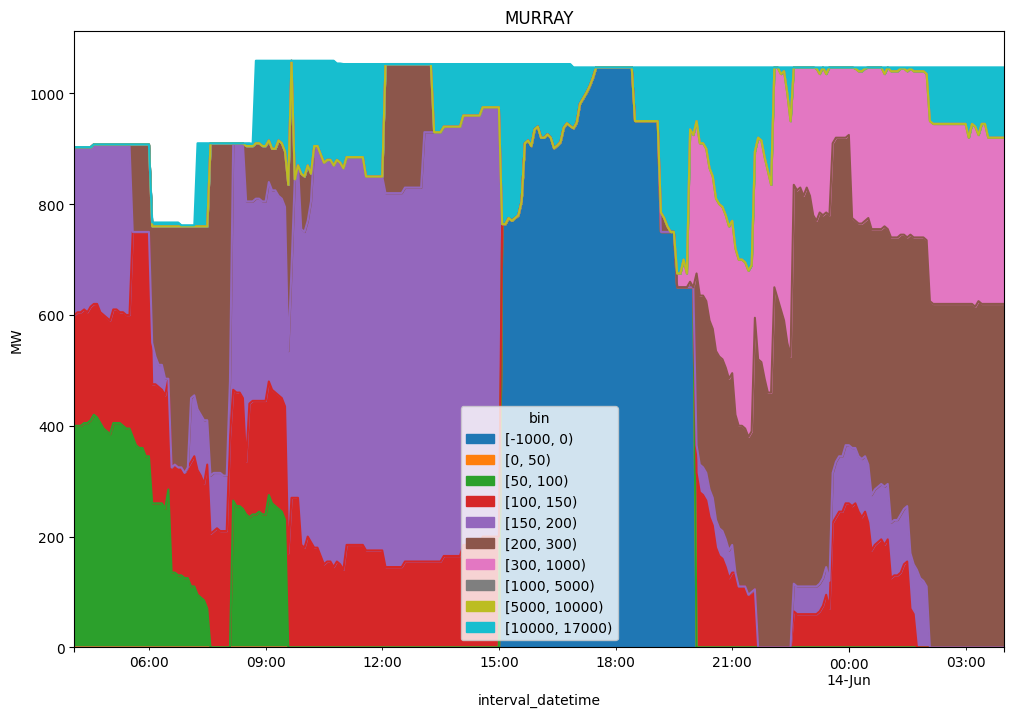

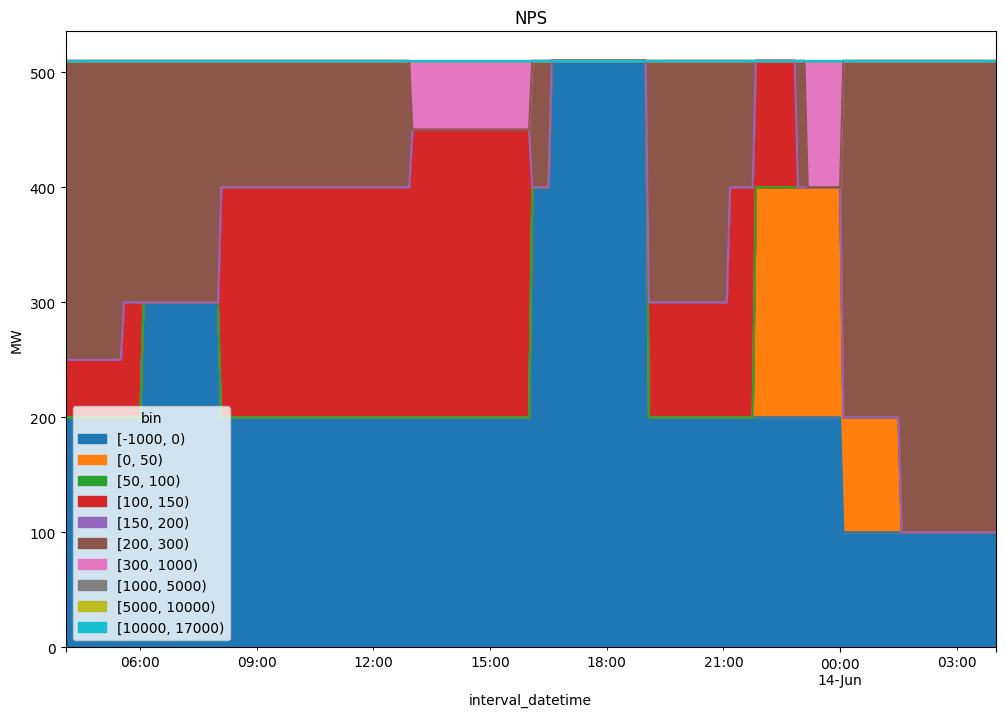

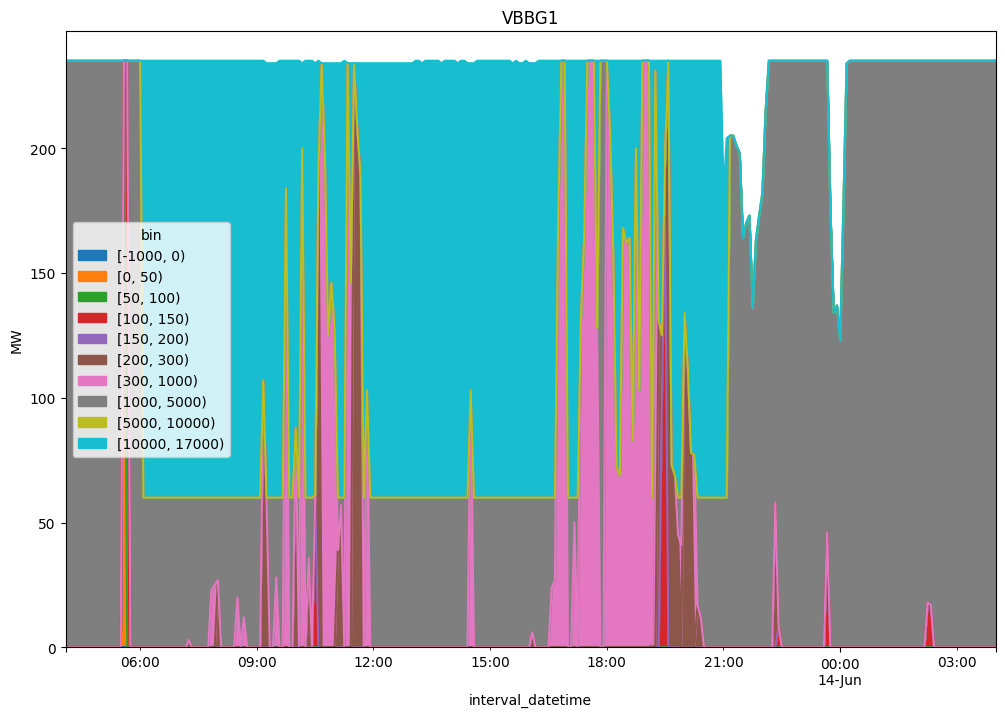

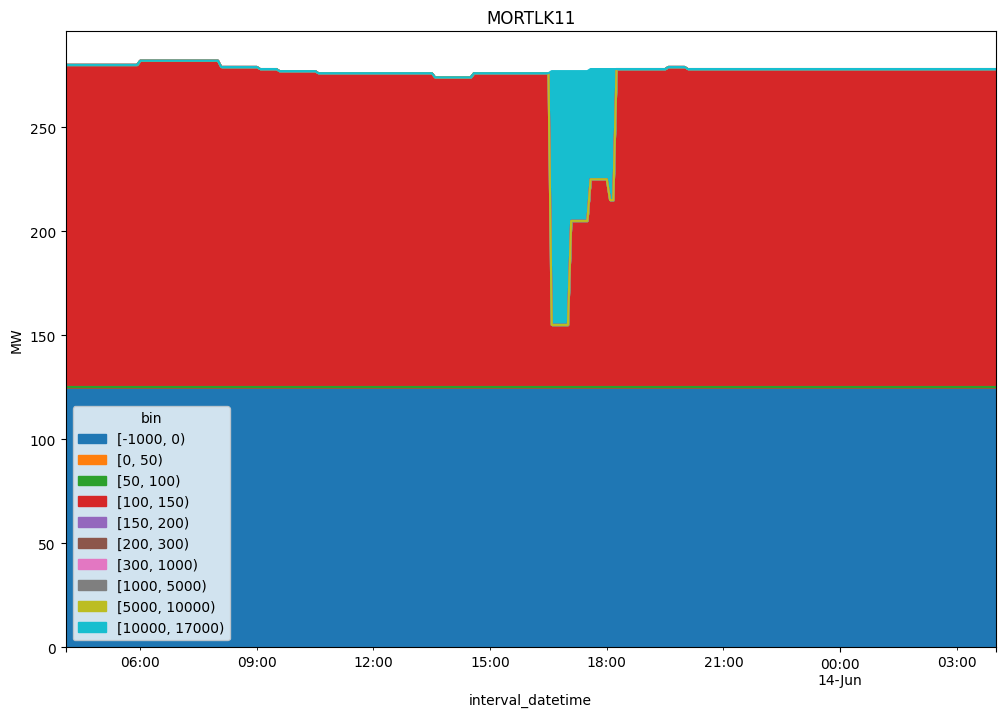

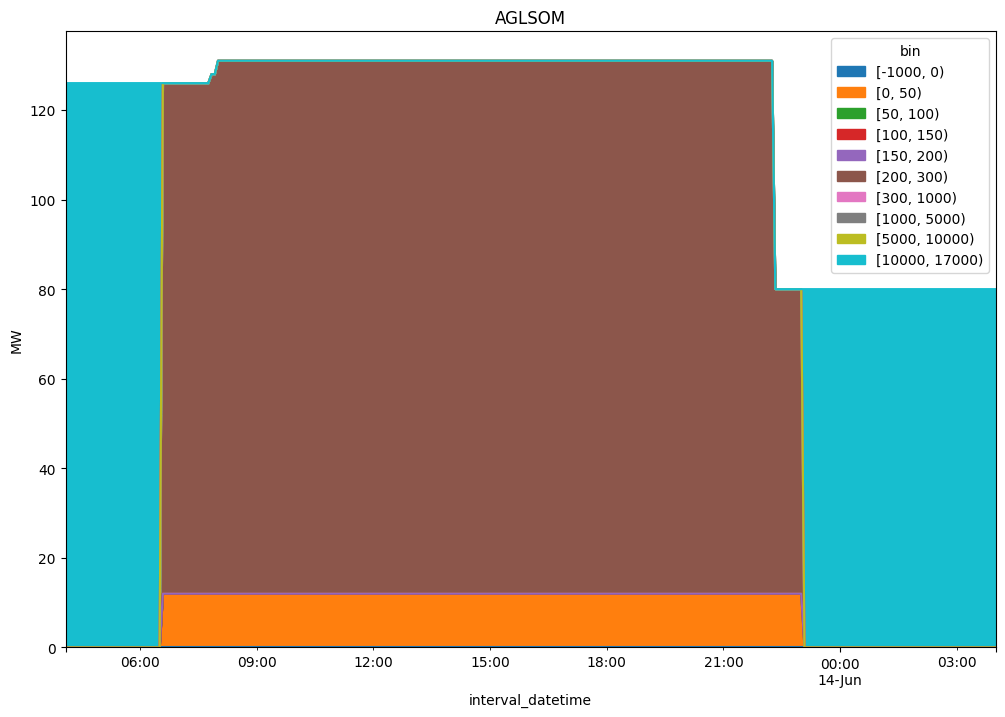

In [36]:
for duid in duids:
    pt.plot_price_band_vol_movement(df_price_band_clusters,duid)

In [39]:
reload(pt)
reload(fn)

<module 'src.functions' from 'c:\\Users\\mostafa.naemi\\OneDrive - ZEN Technologies (Power & Energy) Pty Ltd\\Documents\\Github\\Powerline\\Powerline\\src\\functions.py'>